<a href="https://colab.research.google.com/github/Daito-S/reversi/blob/main/%E8%AA%B2%E9%A1%8C05_12_SD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **リバーシ**

## **概要**
６×６マスのリバーシのプログラムです。

最初の白と黒の設定はランダムで決まります

ボードの上にターン数とどちらのターンかが表示され、クリックによって石の配置ができ、石の裏返しや勝敗判定が自動で行われます。

しかし、相手の石を裏返せない場所に自分の石は置けず、置けるマスが無いと相手のターンになります。

ボードが全て埋まった時や白黒どちらも石を置けなくなった時に白と黒それぞれの数とどちらの勝ちかが表示され終わりとなります。

## **操作方法**
**※1回目は必ずエラーとなります。一度全てのセルを実行してエラーが表示された後に、画面上部の「ランタイム」の項目から「セッションを再起動してすべて実行する」または、「セッションを再起動する」を選択してやり直してください**

縦や横、斜めに自分の色の石で相手の色の石を挟めるような位置を探してそのマスをクリックしてください。

（ボード内で挟めるのなら間にいくつ相手の石があっても裏返せます）


## **制作者のコメント**
苦労した点は、最初にボードを表示させた際、クリックが反応しない問題があり、それの解決に時間がかかりました。

反省点もクリックに関することで、結果的にクリックは反応するようになりましたが、最初に必ずセッションの再起動をしないとエラーが出てしまう原因が分からずこの問題は解決できなかったことです。

家族と遊んだり一人で遊んだりして、６×６マスだとどちらかが置けなくなることが比較的多く、一回遊ぶのに必要な時間も少な目に感じたので普通のリバーシよりしっかり考えて遊ぶことができると思います。
そしてリバーシは角を取る、取らせないことが重要だとよく聞きますが、６×６マスの場合は角というより**端のマスを多く取ることが重要**だと感じました。

（オセロはメガハウスの登録商標らしいのですが、一般的に日本ではオセロとリバーシは同じものを指す言葉となっていますし、非営利なので大丈夫だとは思いますが、タイトルは”リバーシ”としました。）
## **作成時間**

作成時間：**約17時間**

In [ ]:
# ライブラリのインストール
!pip install matplotlib ipywidgets ipympl

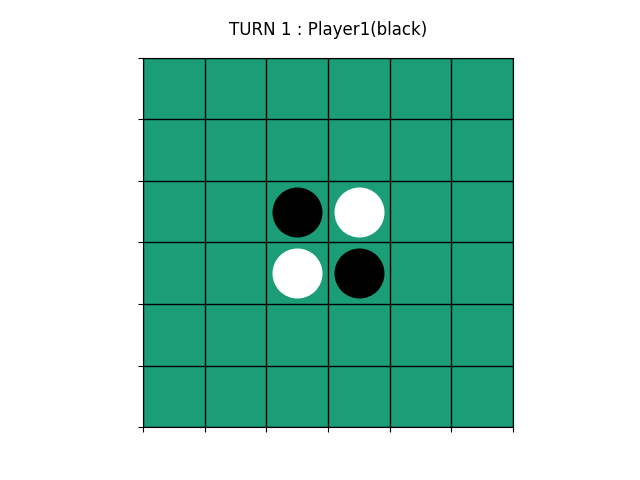

In [ ]:
%reset -f
%matplotlib widget

####ライブラリのインストール####

from google.colab import output #クリックに反応させるために必須
output.enable_custom_widget_manager()
# import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display,clear_output
import ipywidgets as widgets
import random


####変数の定義####

#プレイヤー情報
P1 = {
    'name'     : 'Player1',
    'color'    : '',
    'amount'   : 0
}

P2 = {
    'name'     : 'Player2',
    'color'    : '',
    'amount'   : 0
}

#方向
direction = {
    'TopLeft'    : [[-1,-1],0],
    'Top'        : [[-1,0],1],
    'TopRight'   : [[-1,1],2],
    'Left'       : [[0,-1],3],
    'Right'      : [[0,1],4],
    'BottomLeft' : [[1,-1],5],
    'Bottom'     : [[1,0],6],
    'BottomRight': [[1,1],7]
}
direction_list = ['TopLeft','Top','TopRight','Left','Right','BottomLeft','Bottom','BottomRight']

disc_list = ['white','black'] #白黒のリスト(randomでP1・P2を決めるので空白は無し)
reversed_correct = [0]*8 #裏返す石があったか確認するためのリスト
turn_text = None # ターン表示用のテキストオブジェクト


####関数の定義####

#クリックによるターン全体の処理の関数
def on_click(event):
  global Turn,turn_text
  ###範囲内かどうか判別###
  #範囲外の時は処理しない
  if event.inaxes is None or event.xdata is None or event.ydata is None:
    return

  #範囲内の時は処理する
  click_x = int(event.xdata + 0.5)
  click_y = int(event.ydata + 0.5)
  global turn_text # turn_textをグローバル変数として使用する宣言

  ###すでに石が置かれているなら処理しない###
  if disc_map[click_x][click_y] == 1 or disc_map[click_x][click_y] == 2:
    return

  ###ターンの処理###
  #2で割り切れない -> Player1の番
  if Turn % 2 == 1:
    #置く場所があるとき
    if disc_placeble(1) == True:
      turn(click_x, click_y, 1)
    #置く場所がない時相手のターンにする、互いにもう置けない場合があるのでここで終了せず勝敗判定もする
    else:
      Turn += 1
      turn_text.remove()
      turn_text = ax.text(2.5, -0.8, f"TURN {Turn} : {P2['name']}({P2['color']})", ha='center', va='bottom', fontsize=12)
      fig.canvas.draw()

  #2で割り切れる -> Player2の番
  else:
    #置く場所があるとき
    if disc_placeble(2) == True:
      turn(click_x, click_y, 2)
    #置く場所がない時
    else:
      Turn += 1
      turn_text.remove()
      turn_text = ax.text(2.5, -0.8, f"TURN {Turn} : {P1['name']}({P1['color']})", ha='center', va='bottom', fontsize=12)
      fig.canvas.draw()

  ###勝敗判定###
  if disc_placeble(1) == False and disc_placeble(2) == False: #互いに置けない時
    final()
  for i in range(3):
    if i not in disc_map: #空白・それぞれの石がなくなったら
      final()

  # 図の更新
  fig.canvas.draw()

#指定された方向で挟める石がひとつでもあるか判別する関数
def search_reversible(x,y,t):
    #リストの初期化
    global first_disc_reversible
    first_disc_reversible = [0] * 8

    #8方向分繰り返す
    for i,d in enumerate(direction_list):
      nx, ny = x + direction[d][0][0], y + direction[d][0][1]
      #隣が相手の石でなければ処理しない
      if not (0 <= nx <= 5 and 0 <= ny <= 5 and disc_map[nx][ny] != t and disc_map[nx][ny] != 0):
        continue
      #相手の石がどこまで続くか調べる
      while 0 <= nx <= 5 and 0 <= ny <= 5 and disc_map[nx][ny] != t and disc_map[nx][ny] != 0:
        nx += direction[d][0][0]; ny += direction[d][0][1]
      #そこから一つ先が範囲外、自分の石、空白なら挟めないので終了
      if not(0 <= nx <= 5 and 0 <= ny <= 5 and disc_map[nx][ny] == t):
        continue
      #相手の石を挟めるならその方向の部分のリストに1を代入
      else:
        first_disc_reversible[i] = 1

#石を裏返す関数
def reverse(x,y,t): #x,yは座標、tはターン1か2
  global reversed_correct
  reversed_correct = [0]*8
  for i,d in enumerate(direction_list):
    if first_disc_reversible[i] == 1: #挟める方向の時処理する
      nx, ny = x + direction[d][0][0], y + direction[d][0][1]

      #相手の石がどこまで続くか調べる
      while 0 <= nx <= 5 and 0 <= ny <= 5 and disc_map[nx][ny] != t and disc_map[nx][ny] != 0:
        disc_map[nx][ny] = t
        nx += direction[d][0][0]; ny += direction[d][0][1]
      #裏返せたことを記録
      reversed_correct[i] = 1

#ターン処理の関数
def turn(x,y,t):
  global Turn,turn_text #グローバル変数として宣言
  search_reversible(x,y,t)
  reverse(x,y,t)
  #クリックした場所に石を置く
  if 1 in reversed_correct: #裏返せた時のみ
    disc_map[x][y] = t
    place_disc()
    Turn += 1 #ターンを次に進める
    # 古いテキストを削除して新しいテキストを描画
    if turn_text:
        turn_text.remove()
        if t == 1:
          turn_text = ax.text(2.5, -0.8, f"TURN {Turn} : {P2['name']}({P2['color']})", ha='center', va='bottom', fontsize=12)
        else:
          turn_text = ax.text(2.5, -0.8, f"TURN {Turn} : {P1['name']}({P1['color']})", ha='center', va='bottom', fontsize=12)
  else:
    return

#残っているマスに石を置けるか判断する関数
def disc_placeble(t):
    for i in range(6):
      for j in range(6):
        if disc_map[i][j] == 0:
          search_reversible(i,j,t)
          if 1 in first_disc_reversible:
          #残っているならTrue
            return True
    #残ってないならFalse
    return False

#勝敗判定の関数
def final():
  global turn_text, win_text
  #ゼロではないそれぞれの要素の数を数える
  P1['amount'] = np.count_nonzero(disc_map == 1)
  P2['amount'] = np.count_nonzero(disc_map == 2)
  #文字表示
  turn_text.remove()
  turn_text = ax.text(2.5, -0.6, f"{P1['name']}({P1['color']}):{P1['amount']}  {P2['name']}({P2['color']}):{P2['amount']}", ha='center', va='bottom', fontsize=12)
  if P1['amount'] > P2['amount']:
    win_text = ax.text(2.5,-0.9,f"{P1['name']} WIN!", ha='center',va='bottom',fontsize=20)
  elif P1['amount'] < P2['amount']:
    win_text = ax.text(2.5,-0.9,f"{P2['name']} WIN!", ha='center',va='bottom',fontsize=20)
  else:
    win_text = ax.text(2.5,-0.9,"DROW", ha='center',va='bottom',fontsize=20)

#マス目の描画の関数
def draw_grid():
  ax.set_xticks(np.arange(-0.5, 6, 1))
  ax.set_yticks(np.arange(-0.5, 6, 1))
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.grid(color='black', linewidth=1)

#石配置の関数
def place_disc():
  # ax.clear()
  # draw_grid()
  for i in range(6):
    for j in range(6):
      if disc_map[i][j]==1:
        ax.plot(i,j,marker='o',markersize='35',color=P1['color'])
      elif disc_map[i][j]==2:
        ax.plot(i,j,marker='o',markersize='35',color=P2['color'])


####ゲームの初期化と実行####

plt.close('all') #既存のmatplotlibの図を全て閉じる
Turn = 1 # ターンを初期化

#初めの白黒の決定
random.shuffle(disc_list)  #プレイヤーの白黒を決定
disc_list.insert(0,'None') #リストの始めに空白を追加
P1['color'] = disc_list[1]
P2['color'] = disc_list[2]

###マップ初期設定###
#図と軸を作成
board = np.zeros((6,6)) #ゼロで埋められた6×6マスを作成
fig, ax = plt.subplots() #figureは土台・axはボード
im = ax.imshow(board, cmap='Dark2', vmin=0, vmax=9) #ボード表示
draw_grid() #マス目も表示

#石の配列
disc_map = np.zeros((6,6))
#中央4つに石を配置、表示
for i in range(2):
  for j in range(2):
    disc_map[i+2][j+2] = abs(i-j)+1
place_disc()

# プレイヤーのターン表示テキストを初期描画
turn_text = ax.text(2.5, -0.8, f"TURN {Turn} : {P1['name']}({P1['color']})", ha='center', va='bottom', fontsize=12)


#クリックのイベントを登録
cid = fig.canvas.mpl_connect('button_press_event',on_click)

#表示・入力受付開始
plt.show()